In [74]:
import matplotlib.pyplot as plt
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
import itertools
import json
import math
import vector

### Defining Functions

In [75]:
def extract_particle_data(lhe_file, particle_ids):
    """Extract data for specific particle IDs from the LHE file."""
    
    events = read_lhe_with_attributes(lhe_file)

    num_events = read_num_events(lhe_file)

    particle_data = []


    if not isinstance(particle_ids, list):
        particle_ids = [particle_ids] 


    for event_index, event in enumerate(itertools.islice(events, num_events)):
        for particle in event.particles:

            if particle.id in particle_ids:  
                particle_data.append({
                    'event': event_index,
                    'id': particle.id,
                    'px': particle.px,
                    'py': particle.py,
                    'pz': particle.pz,
                    'E': particle.e,
                    'status': particle.status
                })

    return particle_data

def extract_kinematic_data(particle_data):
    """Extract transverse momentum (pT), pseudorapidity (eta), and azimuthal angle (phi) for each particle."""
    kinematic_data = []


    for particle in particle_data:
        px, py, pz = particle['px'], particle['py'], particle['pz']


        pt = math.sqrt(px**2 + py**2)


        phi = math.atan2(py, px)


        theta = math.acos(pz / math.sqrt(px**2 + py**2 + pz**2))
        eta = -math.log(math.tan(theta / 2))


        kinematic_data.append({
            'pt': pt,
            'eta': eta,
            'phi': phi,
        })

    return kinematic_data


### Validation Functions

In [189]:
def invariant_mass_check(vector_1, vector_2):
    inv_masss_1 = vector_1.E**2 - ( vector_1.px**2 + vector_1.py**2 + vector_1.pz**2 )
    inv_masss_2 = vector_2.E**2 - ( vector_2.px**2 + vector_2.py**2 + vector_2.pz**2 )

    mass_diff = np.isclose(inv_masss_1, inv_masss_2, atol=1e-7)
    
    if np.all(mass_diff):
        print("Invariant mass check passed.")
    else:
        changed_indices = np.where(~mass_diff)[0]
        for idx in changed_indices:
            print(f"Warning: Invariant mass changed at index {idx}! Initial: {vector_1.mass[idx]}, Final: {vector_2.mass[idx]}")
    
    return
def momentum_conservation_check(muon_vector, anti_muon_vector):

    total_px = muon_vector.px + anti_muon_vector.px
    total_py = muon_vector.py + anti_muon_vector.py
    total_pz = muon_vector.pz + anti_muon_vector.pz

    px_check = np.isclose(total_px, 0, atol=1e-7)
    py_check = np.isclose(total_py, 0, atol=1e-7)
    pz_check = np.isclose(total_pz, 0, atol=1e-7)

    # Check for px
    if np.all(px_check):
        print("Momentum conservation check passed for px.")
    else:
        failed_indices = np.where(~px_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total px failed at index {idx}: Value = {total_px[idx]}")

    # Check for py
    if np.all(py_check):
        print("Momentum conservation check passed for py.")
    else:
        failed_indices = np.where(~py_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total py failed at index {idx}: Value = {total_py[idx]}")

    # Check for pz
    if np.all(pz_check):
        print("Momentum conservation check passed for pz.")
    else:
        failed_indices = np.where(~pz_check)[0]
        for idx in failed_indices:
            print(f"Warning: Total pz failed at index {idx}: Value = {total_pz[idx]}")

    # Final summary
    overall_passed = np.all(px_check) and np.all(py_check) and np.all(pz_check)
    if overall_passed:
        print("Momentum conservation check passed: Total momentum is zero.")
    else:
        print("Momentum conservation check failed.")

    return overall_passed

def rotation_check(original_vector, rotated_vector, rotation_axis, tolerance=1e-7):


    # Normalize the rotation axis
    rotation_axis_norm = abs(rotation_axis)
    if rotation_axis_norm < tolerance:
        print("The rotation axis is too small or zero.")
        return False

    rotation_axis_normalized = [
        rotation_axis.px / rotation_axis_norm,
        rotation_axis.py / rotation_axis_norm,
        rotation_axis.pz / rotation_axis_norm
    ]

    # Normalize original and rotated vectors
    original_norm = abs(original_vector)
    rotated_norm = abs(rotated_vector)

    # Check if both vectors are non-zero
    if np.all(original_norm < tolerance) or np.all(rotated_norm < tolerance):
        print("One of the vectors is too small or zero.")
        return False

    # Get the angle between the original and rotated vectors using the dot product
    dot_product = (rotation_axis.px * rotated_vector.px +
                   rotation_axis.py * rotated_vector.py +
                   rotation_axis.pz * rotated_vector.pz)

    angle = np.arccos(dot_product / (rotation_axis_norm * rotated_norm))
    angle_deg = np.degrees(angle)

    # Check the angle to determine if the rotation is correct
    # The expected angle depends on your application; you can set it or calculate it based on the specific rotation
    expected_angle_1 = np.full(angle_deg.shape, 0)  # Same size as angle_deg
    expected_angle_2 = np.full(angle_deg.shape, 180.0)  # Same size as angle_deg

    
    angle_diff_1 = np.isclose(angle_deg, expected_angle_1, atol=tolerance)
    angle_diff_2 = np.isclose(angle_deg, expected_angle_2, atol=tolerance)
    combined_angle_diff = np.logical_or(angle_diff_1, angle_diff_2)


    if np.all(combined_angle_diff):
        print("Rotation check passed for the given axis.")

    else:
        changed_indices = np.where(~combined_angle_diff)[0]
        for idx in changed_indices:
            print(f"Warning: Rotation check failed at Index {idx}."
              f"Calculated angle: {angle_deg[idx]} degrees.")

# Example usage:
# rotation_check(original_vector, rotated_vector, rotation_axis=vector.obj(0, 0, 1))



In [190]:
muon_four_momentum_com = rotate_and_boost(muon_four_momentum, com_four_momentum, z_axis)


Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.


In [152]:
def contruct_four_vector(data_set):

    four_vector = vector.array({"E": [data["E"] for data in data_set], 
                                "px": [data["px"] for data in data_set], 
                                "py": [data["py"] for data in data_set], 
                                "pz": [data["pz"] for data in data_set]})
    
    return four_vector

def construct_three_momentum(four_vector):

    three_momentum = vector.array({"px": four_vector.px, 
                                   "py": four_vector.py, 
                                   "pz": four_vector.pz})
    return three_momentum

def find_decay_angle(four_vector):
    cos_theta =  four_vector.pz / np.sqrt(four_vector.px**2 + four_vector.py**2 + four_vector.pz**2)
    #cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)

    return theta

def rotate_and_boost(affected_vector, reference_vector, axis):

    reference_three_vector = construct_three_momentum(reference_vector)
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / ((np.sqrt(reference_three_vector.px**2 + reference_three_vector.py**2 + reference_three_vector.pz**2)) * abs(axis))

    rotation_angles = np.arccos(cos_theta)

    transverse_momenta = np.sqrt(affected_vector.px**2 + affected_vector.py**2)
    non_zero_mask = transverse_momenta > 0
    rotated_reference_three_vector = reference_three_vector
    rotated_reference_three_vector[non_zero_mask] = reference_three_vector[non_zero_mask].rotate_axis(rotation_axes, rotation_angles)
    rotation_check(reference_three_vector, rotated_reference_three_vector, axis)


    rotated_reference_four_vector = vector.array({"E": reference_vector.E, "px": rotated_reference_three_vector.px, "py": rotated_reference_three_vector.py, "pz": rotated_reference_three_vector.pz})
    invariant_mass_check(reference_vector, rotated_reference_four_vector)

    rotated_affected_vector = affected_vector
    rotated_affected_vector[non_zero_mask] = affected_vector[non_zero_mask].rotate_axis(rotation_axes, rotation_angles)
    invariant_mass_check(affected_vector, rotated_affected_vector)

    boost_vector = rotated_reference_four_vector.to_beta3()
    rotated_boosted_affected_vector = rotated_affected_vector.boost(-boost_vector)
    invariant_mass_check(rotated_affected_vector, rotated_boosted_affected_vector)

    return rotated_boosted_affected_vector


In [211]:
def rotate_and_boost(affected_vector, reference_vector, axis):
    
    reference_three_vector = construct_three_momentum(reference_vector)
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / ((np.sqrt(reference_three_vector.px**2 + reference_three_vector.py**2 + reference_three_vector.pz**2)) * abs(axis))
    rotation_angles = np.arccos(cos_theta)

    rotated_reference_vector_x = (
            (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.x**2) * reference_vector.x 
            + (rotation_axes.x * rotation_axes.y * (1 - np.cos(rotation_angles))) * reference_vector.y 
            + rotation_axes.y * np.sin(rotation_angles) * reference_vector.z
        )
    
    rotated_reference_vector_y = (
            rotation_axes.px * rotation_axes.py * (1 - np.cos(rotation_angles)) * reference_vector.px
            + (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.py**2) * reference_vector.py
            - rotation_axes.px * np.sin(rotation_angles) * reference_vector.pz
        )
        
    rotated_reference_vector_z = (
            -rotation_axes.py * np.sin(rotation_angles) * reference_vector.px
            + rotation_axes.px * np.sin(rotation_angles) * reference_vector.py 
            + np.cos(rotation_angles) * reference_vector.pz
        )


    rotated_affected_vector_x = (
            (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.x**2) * affected_vector.x 
            + (rotation_axes.x * rotation_axes.y * (1 - np.cos(rotation_angles))) * affected_vector.y 
            + rotation_axes.y * np.sin(rotation_angles) * affected_vector.z
        )
    
    rotated_affected_vector_y = (
            rotation_axes.px * rotation_axes.py * (1 - np.cos(rotation_angles)) * affected_vector.px
            + (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.py**2) * affected_vector.py
            - rotation_axes.px * np.sin(rotation_angles) * affected_vector.pz
        )
        
    rotated_affected_vector_z = (
            -rotation_axes.py * np.sin(rotation_angles) * affected_vector.px
            + rotation_axes.px * np.sin(rotation_angles) * affected_vector.py 
            + np.cos(rotation_angles) * affected_vector.pz
        )

    rotated_reference_four_vector = vector.array({"E": reference_vector.E, "px": rotated_reference_vector_x, "py": rotated_reference_vector_y, "pz": rotated_reference_vector_z})
    invariant_mass_check(reference_vector, rotated_reference_four_vector)

    rotated_affected_four_vector = vector.array({"E": affected_vector.E, "px": rotated_affected_vector_x, "py": rotated_affected_vector_y, "pz": rotated_affected_vector_z})
    invariant_mass_check(affected_vector, rotated_affected_four_vector)


    boost_vector = rotated_reference_four_vector.to_beta3()
    rotated_boosted_affected_vector = rotated_affected_four_vector.boost(-boost_vector)
    invariant_mass_check(rotated_affected_four_vector, rotated_boosted_affected_vector)

    return rotated_boosted_affected_vector



In [258]:
def rotate_vector(vector, rotation_axes, rotation_angles):

    rotated_x = np.array(
        (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.x**2) * vector.x +
        (rotation_axes.x * rotation_axes.y * (1 - np.cos(rotation_angles))) * vector.y +
        rotation_axes.y * np.sin(rotation_angles) * vector.z
    )
    
    rotated_y = np.array(
        rotation_axes.px * rotation_axes.py * (1 - np.cos(rotation_angles)) * vector.px +
        (np.cos(rotation_angles) + (1 - np.cos(rotation_angles)) * rotation_axes.py**2) * vector.py -
        rotation_axes.px * np.sin(rotation_angles) * vector.z
    )
        
    rotated_z = np.array(
        -rotation_axes.py * np.sin(rotation_angles) * vector.px +
        rotation_axes.px * np.sin(rotation_angles) * vector.py +
        np.cos(rotation_angles) * vector.z
    )
    print(vector.E)
    
    rotated_vector = vector.array({"E": vector.E, "px": rotated_x, "py": rotated_y,"pz": rotated_z}) 

    return rotated_vector

def boost_vector(affected_vector, reference_vector):
    
    beta = reference_vector.pz / reference_vector.E
    gamma = 1 / np.sqrt(1 - beta**2)

    E_boosted = gamma * (affected_vector.E - beta*affected_vector.pz)
    pz_boosted = gamma * (affected_vector.pz - beta * affected_vector.E )
    px_boosted = affected_vector.px
    py_boosted = affected_vector.pz

    boosted_vector = vector.array({"E": E_boosted, "px": px_boosted, "py": py_boosted,"pz": pz_boosted}) 


    return boosted_vector


def rotate_and_boost(affected_vector, reference_vector, axis):

    reference_three_vector = construct_three_momentum(reference_vector)
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / abs(reference_three_vector) * abs(axis)
    rotation_angles = np.arccos(cos_theta)

    # Rotate reference vector
    rotated_reference_four_vector = rotate_vector(reference_vector, rotation_axes, rotation_angles)
    rotated_reference_three_vector = vector.array({"px": rotated_reference_four_vector.px, "py": rotated_reference_four_vector.py,"pz": rotated_reference_four_vector.pz}) 
    invariant_mass_check(reference_vector, rotated_reference_four_vector)
    rotation_check(reference_three_vector, rotated_reference_three_vector, axis)

    # Rotate affected vector
    rotated_affected_vector_x, rotated_affected_vector_y, rotated_affected_vector_z = rotate_vector(affected_vector, rotation_axes, rotation_angles)
    
    rotated_affected_four_vector = vector.array({"E": affected_vector.E, "px": rotated_affected_vector_x, "py": rotated_affected_vector_y,"pz": rotated_affected_vector_z}) 
    invariant_mass_check(affected_vector, rotated_affected_four_vector)

    # Boost the affected vector
    boost_vector = rotated_reference_four_vector.to_beta3()
    rotated_boosted_affected_vector = rotated_affected_four_vector.boost(-boost_vector)
    invariant_mass_check(rotated_affected_four_vector, rotated_boosted_affected_vector)

    return rotated_boosted_affected_vector


In [259]:
z_four_momentum_com = rotate_and_boost(z_four_momentum, com_four_momentum, z_axis)


[5387.41845507  909.02886084 1622.84623746 ... 1496.74775614  841.25685715
  608.61941267]


AttributeError: 'MomentumNumpy4D' object has no attribute 'array'

In [130]:



def rotate_and_boost2(affected_vector, reference_vector, axis):
    reference_three_vector = construct_three_momentum(reference_vector)
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / (abs(reference_three_vector) * abs(axis))
    #cos_theta = np.clip(reference_three_vector.dot(axis) / (abs(reference_three_vector) * abs(axis)), -1, 1)

    rotation_angles = np.arccos(cos_theta)

    rotated_reference_three_vector = reference_three_vector.rotate_axis(rotation_axes, rotation_angles)
    rotated_reference_four_vector = vector.array({"E": reference_vector.E, "px": rotated_reference_three_vector.px, "py": rotated_reference_three_vector.py, "pz": rotated_reference_three_vector.pz})
    rotated_affected_vector = affected_vector.rotate_axis(rotation_axes, rotation_angles)
    
    boost_vector = rotated_reference_four_vector.pz/rotated_reference_four_vector.E
    rotated_boosted_affected_vector = rotated_affected_vector.boostZ(-boost_vector)
    return rotated_boosted_affected_vector



def plot_histogram(data, title, file_name):
    # Filter out NaN and infinite values
    valid_data = data[np.isfinite(data)]
    cos_theta_data = np.cos(valid_data)

    # Count valid events
    num_valid_events = len(valid_data)
    
    # Print the number of valid events
    print(f"Number of valid events (not NaN or Inf): {num_valid_events}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots, stacked vertically

    # First subplot for angle
    ax1.hist(valid_data, bins=50, alpha=0.7, color='blue')
    ax1.set_xlabel('Angle (radians)')
    ax1.set_ylabel('Number of Events')
    ax1.set_title(f"{title} - Angles")
    ax1.grid(axis='y', alpha=0.75)
    ax1.text(0.95, 0.95, f'Number of Events: {num_valid_events}', 
             ha='right', va='top', fontsize=12, transform=ax1.transAxes)

    # Second subplot for cos(theta)
    ax2.hist(cos_theta_data, bins=50, alpha=0.7, color='orange')
    ax2.set_xlabel('cos(θ)')
    ax2.set_ylabel('Number of Muons')
    ax2.set_title(f"{title} - cos(θ)")
    ax2.grid(axis='y', alpha=0.75)
    ax2.text(0.95, 0.95, f'Number of Events: {num_valid_events}', 
             ha='right', va='top', fontsize=12, transform=ax2.transAxes)

    plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # Adjust layout to make room for the overall title
    
    # Correct the file path using forward slashes or raw string
    save_path = r"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\Plots\Polarity" + f"\\{file_name}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

    return



In [77]:
lhe_file = r"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\unweighted_events.lhe"

z_data = extract_particle_data(lhe_file, particle_ids=[23])
muon_data = extract_particle_data(lhe_file, particle_ids=[13])
anti_muon_data = extract_particle_data(lhe_file, particle_ids=[-13])

w_data = extract_particle_data(lhe_file, particle_ids=[24])
electron_neutrino_data = extract_particle_data(lhe_file, particle_ids=[12])
anti_electron_data = extract_particle_data(lhe_file, particle_ids=[-11])

w_anti_data = extract_particle_data(lhe_file, particle_ids=[-24])
electron_data = extract_particle_data(lhe_file, particle_ids=[11])
anti_electron_neutrino_data = extract_particle_data(lhe_file, particle_ids=[-12])

In [240]:
z_four_momentum = contruct_four_vector(z_data)
muon_four_momentum = contruct_four_vector(muon_data)
anti_muon_four_momentum = contruct_four_vector(anti_muon_data)

w_four_momentum = contruct_four_vector(w_data)
electron_neutrino_four_momentum = contruct_four_vector(electron_neutrino_data)
anti_electron_four_momentum = contruct_four_vector(anti_electron_data)

w_anti_four_momentum = contruct_four_vector(w_anti_data)
electron_four_momentum = contruct_four_vector(electron_data)
anti_electron_neutrino_four_momentum = contruct_four_vector(anti_electron_neutrino_data)

com_four_momentum = z_four_momentum + w_four_momentum + w_anti_four_momentum

In [241]:
z_axis = vector.obj(px=0, py=0, pz=1)

z_four_momentum_com = rotate_and_boost(z_four_momentum, com_four_momentum, z_axis)
muon_four_momentum_com = rotate_and_boost(muon_four_momentum, com_four_momentum, z_axis)
anti_muon_four_momentum_com = rotate_and_boost(anti_muon_four_momentum, com_four_momentum, z_axis)


w_four_momentum_com = rotate_and_boost(w_four_momentum, com_four_momentum, z_axis)
electron_neutrino_four_momentum_com = rotate_and_boost(electron_neutrino_four_momentum, com_four_momentum, z_axis)
anti_electron_four_momentum_com = rotate_and_boost(anti_electron_four_momentum, com_four_momentum, z_axis)

w_anti_four_momentum_com = rotate_and_boost(w_anti_four_momentum, com_four_momentum, z_axis)
electron_four_momentum_com = rotate_and_boost(electron_four_momentum, com_four_momentum, z_axis)
anti_electron_neutrino_four_momentum_com = rotate_and_boost(anti_electron_neutrino_four_momentum, com_four_momentum, z_axis)


Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.


In [242]:
muon_four_momentum_z_rest = rotate_and_boost(muon_four_momentum_com, z_four_momentum_com, z_axis)
muon_angles= find_decay_angle(muon_four_momentum_z_rest)

anti_muon_four_momentum_z_rest = rotate_and_boost(anti_muon_four_momentum_com, z_four_momentum_com, z_axis)
anti_muon_angles = find_decay_angle(anti_muon_four_momentum_z_rest)

momentum_conservation_check(muon_four_momentum_z_rest, anti_muon_four_momentum_z_rest)

Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Momentum conservation check failed.


False

Number of valid events (not NaN or Inf): 10000


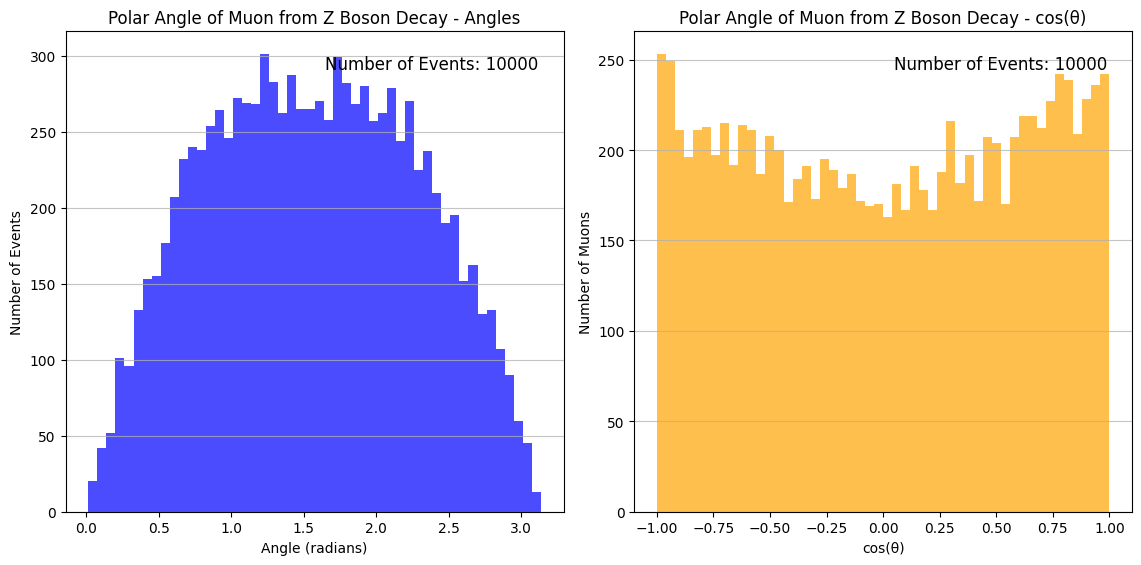

Number of valid events (not NaN or Inf): 10000


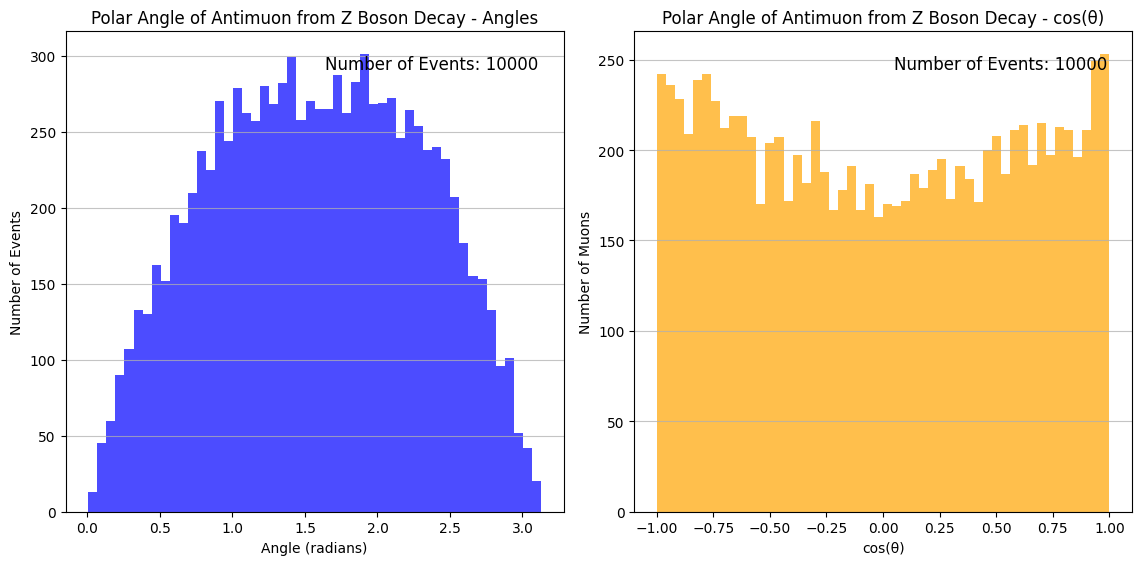

In [243]:
plot_histogram(muon_angles, "Polar Angle of Muon from Z Boson Decay", "Polarity ZBoson (muon)")
plot_histogram(anti_muon_angles, "Polar Angle of Antimuon from Z Boson Decay", "Polarity ZBoson (antimuon)")


In [244]:
electron_neutrino_four_momentum_w_rest = rotate_and_boost(electron_neutrino_four_momentum_com, w_four_momentum_com, z_axis)
electron_neutrino_angles= find_decay_angle(electron_neutrino_four_momentum_w_rest)

anti_electron_four_momentum_z_rest = rotate_and_boost(anti_electron_four_momentum_com, w_four_momentum_com, z_axis)
anti_electron_angles = find_decay_angle(anti_electron_four_momentum_z_rest)

momentum_conservation_check(electron_neutrino_four_momentum_w_rest, anti_electron_four_momentum_z_rest)

Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Momentum conservation check failed.


False

Number of valid events (not NaN or Inf): 10000


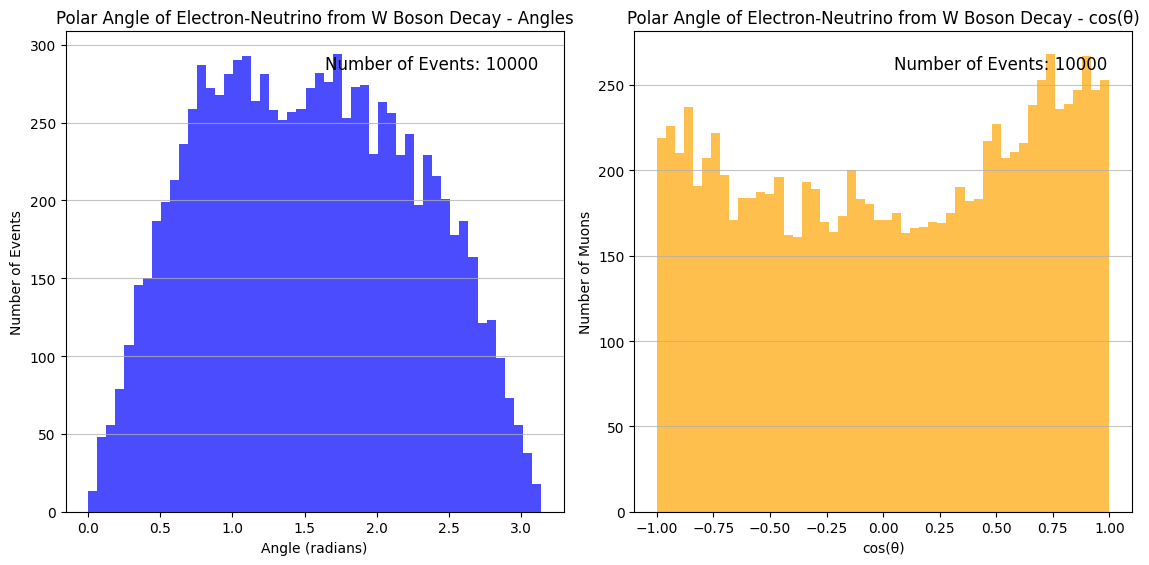

Number of valid events (not NaN or Inf): 10000


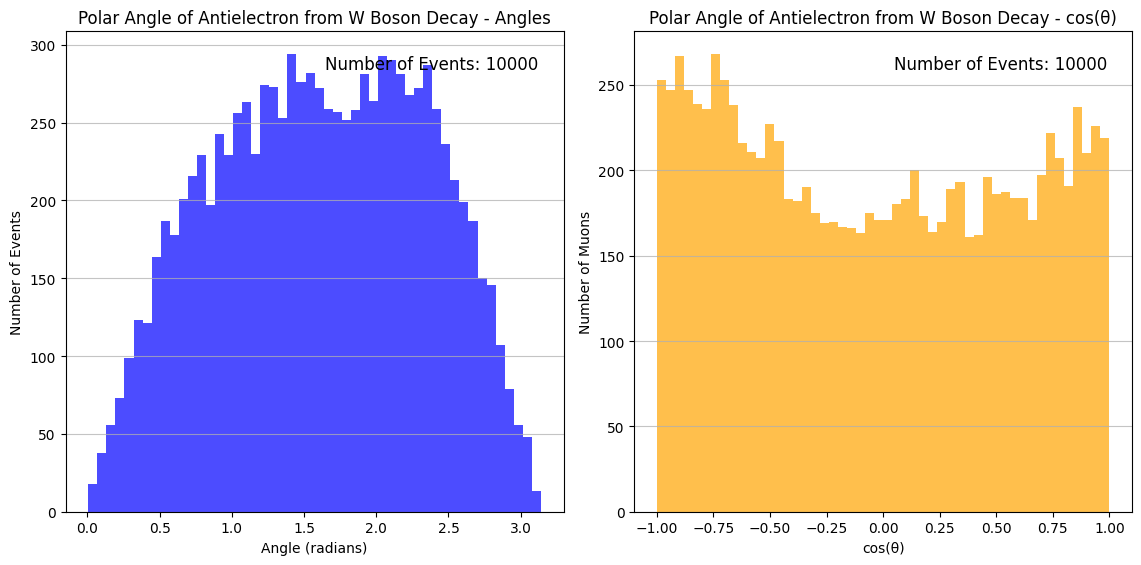

In [245]:
plot_histogram(electron_neutrino_angles, "Polar Angle of Electron-Neutrino from W Boson Decay", "Polarity WBoson (Electron Neutrino)")
plot_histogram(anti_electron_angles, "Polar Angle of Antielectron from W Boson Decay", "Polarity WBoson (Antielectron)")


In [246]:
anti_electron_neutrino_four_momentum_w_rest = rotate_and_boost(anti_electron_neutrino_four_momentum_com, w_anti_four_momentum_com, z_axis)
anti_electron_neutrino_angles= find_decay_angle(anti_electron_neutrino_four_momentum_w_rest)

electron_four_momentum_z_rest = rotate_and_boost(electron_four_momentum_com, w_anti_four_momentum_com, z_axis)
electron_angles = find_decay_angle(electron_four_momentum_z_rest)

Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.


Number of valid events (not NaN or Inf): 10000


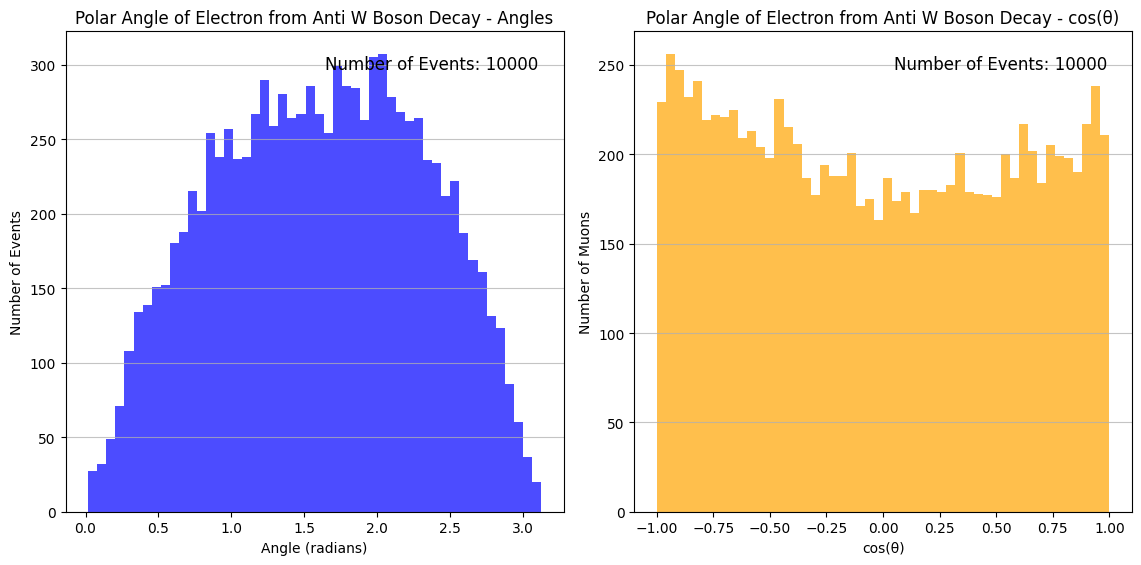

Number of valid events (not NaN or Inf): 10000


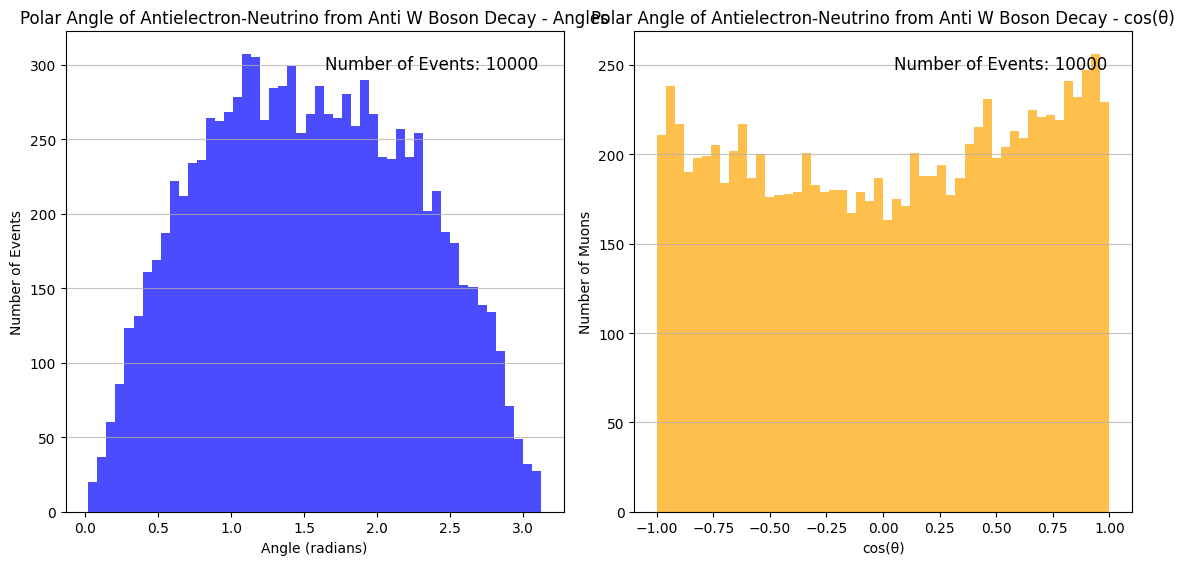

tet


In [247]:
plot_histogram(electron_angles, "Polar Angle of Electron from Anti W Boson Decay", "Polarity Anti WBoson (Electron)")
plot_histogram(anti_electron_neutrino_angles, "Polar Angle of Antielectron-Neutrino from Anti W Boson Decay", "Polarity Anti WBoson (Anti Electron-Neutrino)")
print("tet")
